In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Dataset 1: Data extraction

In [2]:
directory_met = './metadata/' # name of dir containing metadata files
import json
with open(directory_met + 'annot.json','r') as f:
    dico = json.load(f)

In [3]:
arr_names = ['info', 'images', 'annotations', 'licenses']
def dataframe_from_dict(arr_names , dico):
    '''
    creating multiple DataFrames from a given dictionary
    '''
    for name in arr_names:
        if isinstance(dico[name],dict): # checking if it's a dictionary 
            globals()[name] = pd.DataFrame([ list(dico[name].values() )],columns = dico[name].keys())
            print(name,True)
        else:
            globals()[name] = pd.DataFrame.from_dict(dico[name])
            print(name,True)

dataframe_from_dict(arr_names,dico)

info True
images True
annotations True
licenses True


In [4]:
info.head(5) # general information about the dataset

,description,url,creator,date_created,source_images,disclaimer
0,COVID-19 image data collection: Lung Bounding ...,,"General Blockchain, Inc.",04/02/2020,Joseph Paul Cohen and Paul Morrison and Lan Da...,These annotations and images are for proof of ...


In [5]:
licenses.head(5) # License information about the dataset

,url,id,name
0,https://creativecommons.org/licenses/by/4.0/,1,Attribution License


In [6]:
images.head(5) # information about the pictures

,license,file_name,height,width,id,metadata
0,1,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,888,882,1,"{'patientid': '2', 'offset': '0', 'sex': 'M', ..."
1,1,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,891,880,2,"{'patientid': '2', 'offset': '3', 'sex': 'M', ..."
2,1,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,876,882,3,"{'patientid': '2', 'offset': '5', 'sex': 'M', ..."
3,1,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,874,880,4,"{'patientid': '2', 'offset': '6', 'sex': 'M', ..."
4,1,nejmc2001573_f1a.jpeg,1272,1645,5,"{'patientid': '4', 'offset': '0', 'sex': 'F', ..."


In [7]:
# let's turn each entry in the metadata into a distinct column
metadata = pd.DataFrame(list(images['metadata'].values)) # creating a new dataframe from the metadata column
images = pd.concat([images,metadata], axis =1) # concatenating the two dataframes 
images = images.drop(columns = ['metadata'], errors = 'ignore') # removing the metadata column
images.head(5)

,license,file_name,height,width,id,patientid,offset,sex,age,finding,...,doi,url,clinical notes,license,other notes,pO2 saturation,temperature,leukocyte count,lymphocyte count,neutrophil count
0,1,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,888,882,1,2,0,M,65,COVID-19,...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,infiltrate in the upper lobe of the left lung,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,891,880,2,2,3,M,65,COVID-19,...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,progressive infiltrate and consolidation,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,876,882,3,2,5,M,65,COVID-19,...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,progressive infiltrate and consolidation,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,874,880,4,2,6,M,65,COVID-19,...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,progressive infiltrate and consolidation,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,nejmc2001573_f1a.jpeg,1272,1645,5,4,0,F,52,COVID-19,...,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,diffuse infiltrates in the bilateral lower lungs,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# removing un-needed columns
images.drop(columns = ['license','doi','url','license','clinical notes','other notes','date','location'],
            inplace = True, errors = 'ignore')
# turning the male and female values into 1 and 0 respectively
images['sex'][images['sex'] == 'F'] = 0
images['sex'][images['sex'] == 'M'] = 1

# Y as 1 and N as 0 
images['survival'][images['survival'] == 'Y'] = 1
images['survival'][images['survival'] == 'N'] = 0

# categorizing the finding column for ease of processing
dico_findings = {}
finding = ['ARDS','COVID-19','Chlamydophila','E.Coli','Klebsiella',
           'Legionella','No Finding','Pneumocystis','SARS','Streptococcus','COVID-19, ARDS']
for count,finding in  enumerate(finding):
    dico_findings[finding] = count
    images['finding'][images['finding'] == finding] = count
    count+=1
    
# CT as 1 and X-ray as 0 in the modality
images['modality'][images['modality'] == 'CT'] = 1 # we only have 2 CT scans so we will drop them
                                                   # and keep the X-ray scans only
print(f"number of CT scans : {len(images[images['modality'] == 1])} ")
images['modality'][images['modality'] == 'X-ray'] = 0
print(f"number of X-rays: {len(images[images['modality'] == 0])}")

# the following columns have more than 100 out of 167 missing data so we will be droping them
print(f"Missing values in : \n{np.sum(images.isnull())[(np.sum(images.isnull()) > 100)]}")
images.drop(columns = ['temperature','pO2 saturation', 'leukocyte count', 'lymphocyte count',
             'neutrophil count', 'survival'], errors = 'ignore', inplace = True)

# offset (number of days since the start of symptoms or hospitalization for each image, this is very important 
# to have when there are multiple images for the same patient to track progression while being imaged. If a report 
# says "after a few days" let's assume 5 days.)

number of CT scans : 2 
number of X-rays: 165
Missing values in : 
survival            105
pO2 saturation      152
temperature         155
leukocyte count     164
lymphocyte count    165
neutrophil count    166
dtype: int64


# Data visualization and Analysis 

In [9]:
# plotting one picture from each modality and view.

from matplotlib.image import imread
def img_plot(df,each_,name = '',img_per_row = 2,directory = './images/',file_name = 'file_name'):
    '''
    taking the first entry of file_name from each unique of each_ and returning their respective images
    
    df: DataFrame
    each_: column in df
    name : name to show in the title
    img_per_row : number of images in each row
    directory : directory of the image
    file_name : column name of where the image name is
    
    '''
    n_ = len(list(set(df[each_])))
    unique_ = list(set(df[each_]))
    plt.figure(figsize= (5*img_per_row,10*img_per_row))
    
    for each,sub in zip(unique_,range(n_)):
        plt.subplot(n_,img_per_row,sub+1)
        img_ = imread(directory + df[df[each_] == each][file_name].iloc[0])
        plt.imshow(img_)
        plt.title(f'{each} {name}',size = 16)
        plt.axis('off')
    plt.show()

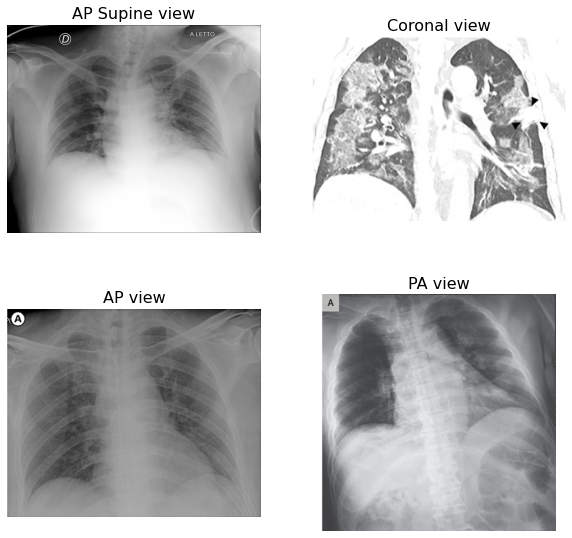

In [10]:
img_plot(images,'view','view')

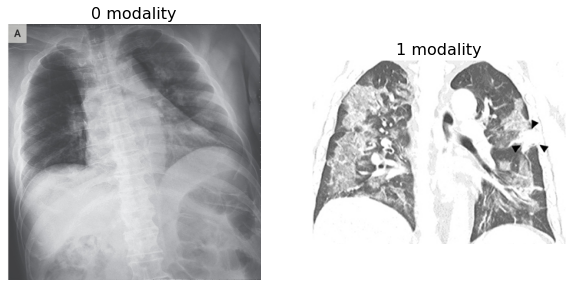

In [11]:
img_plot(images,'modality','modality')

Let's get to know a bit more our first dataset by drawing **repartitions** of different features with respect to the number of pictures

In [12]:
def plot_repartition(x,y,xlabel,ylabel,title,edgecolor = 'c', linewidth = 2,palette = 'hot',yticks = None):
    plt.figure(figsize = (15,7),dpi = 300)
    sns.set(style="whitegrid")
    sns.barplot(y ,x, edgecolor = edgecolor, linewidth = linewidth,orient = 'h',palette = palette)
    if yticks != None:
        plt.yticks(yticks[0], yticks[1], size= 9)
    plt.ylabel(xlabel,size = 16)
    plt.xlabel(ylabel,size = 16)
    plt.title(title, size = 16)
    plt.show()

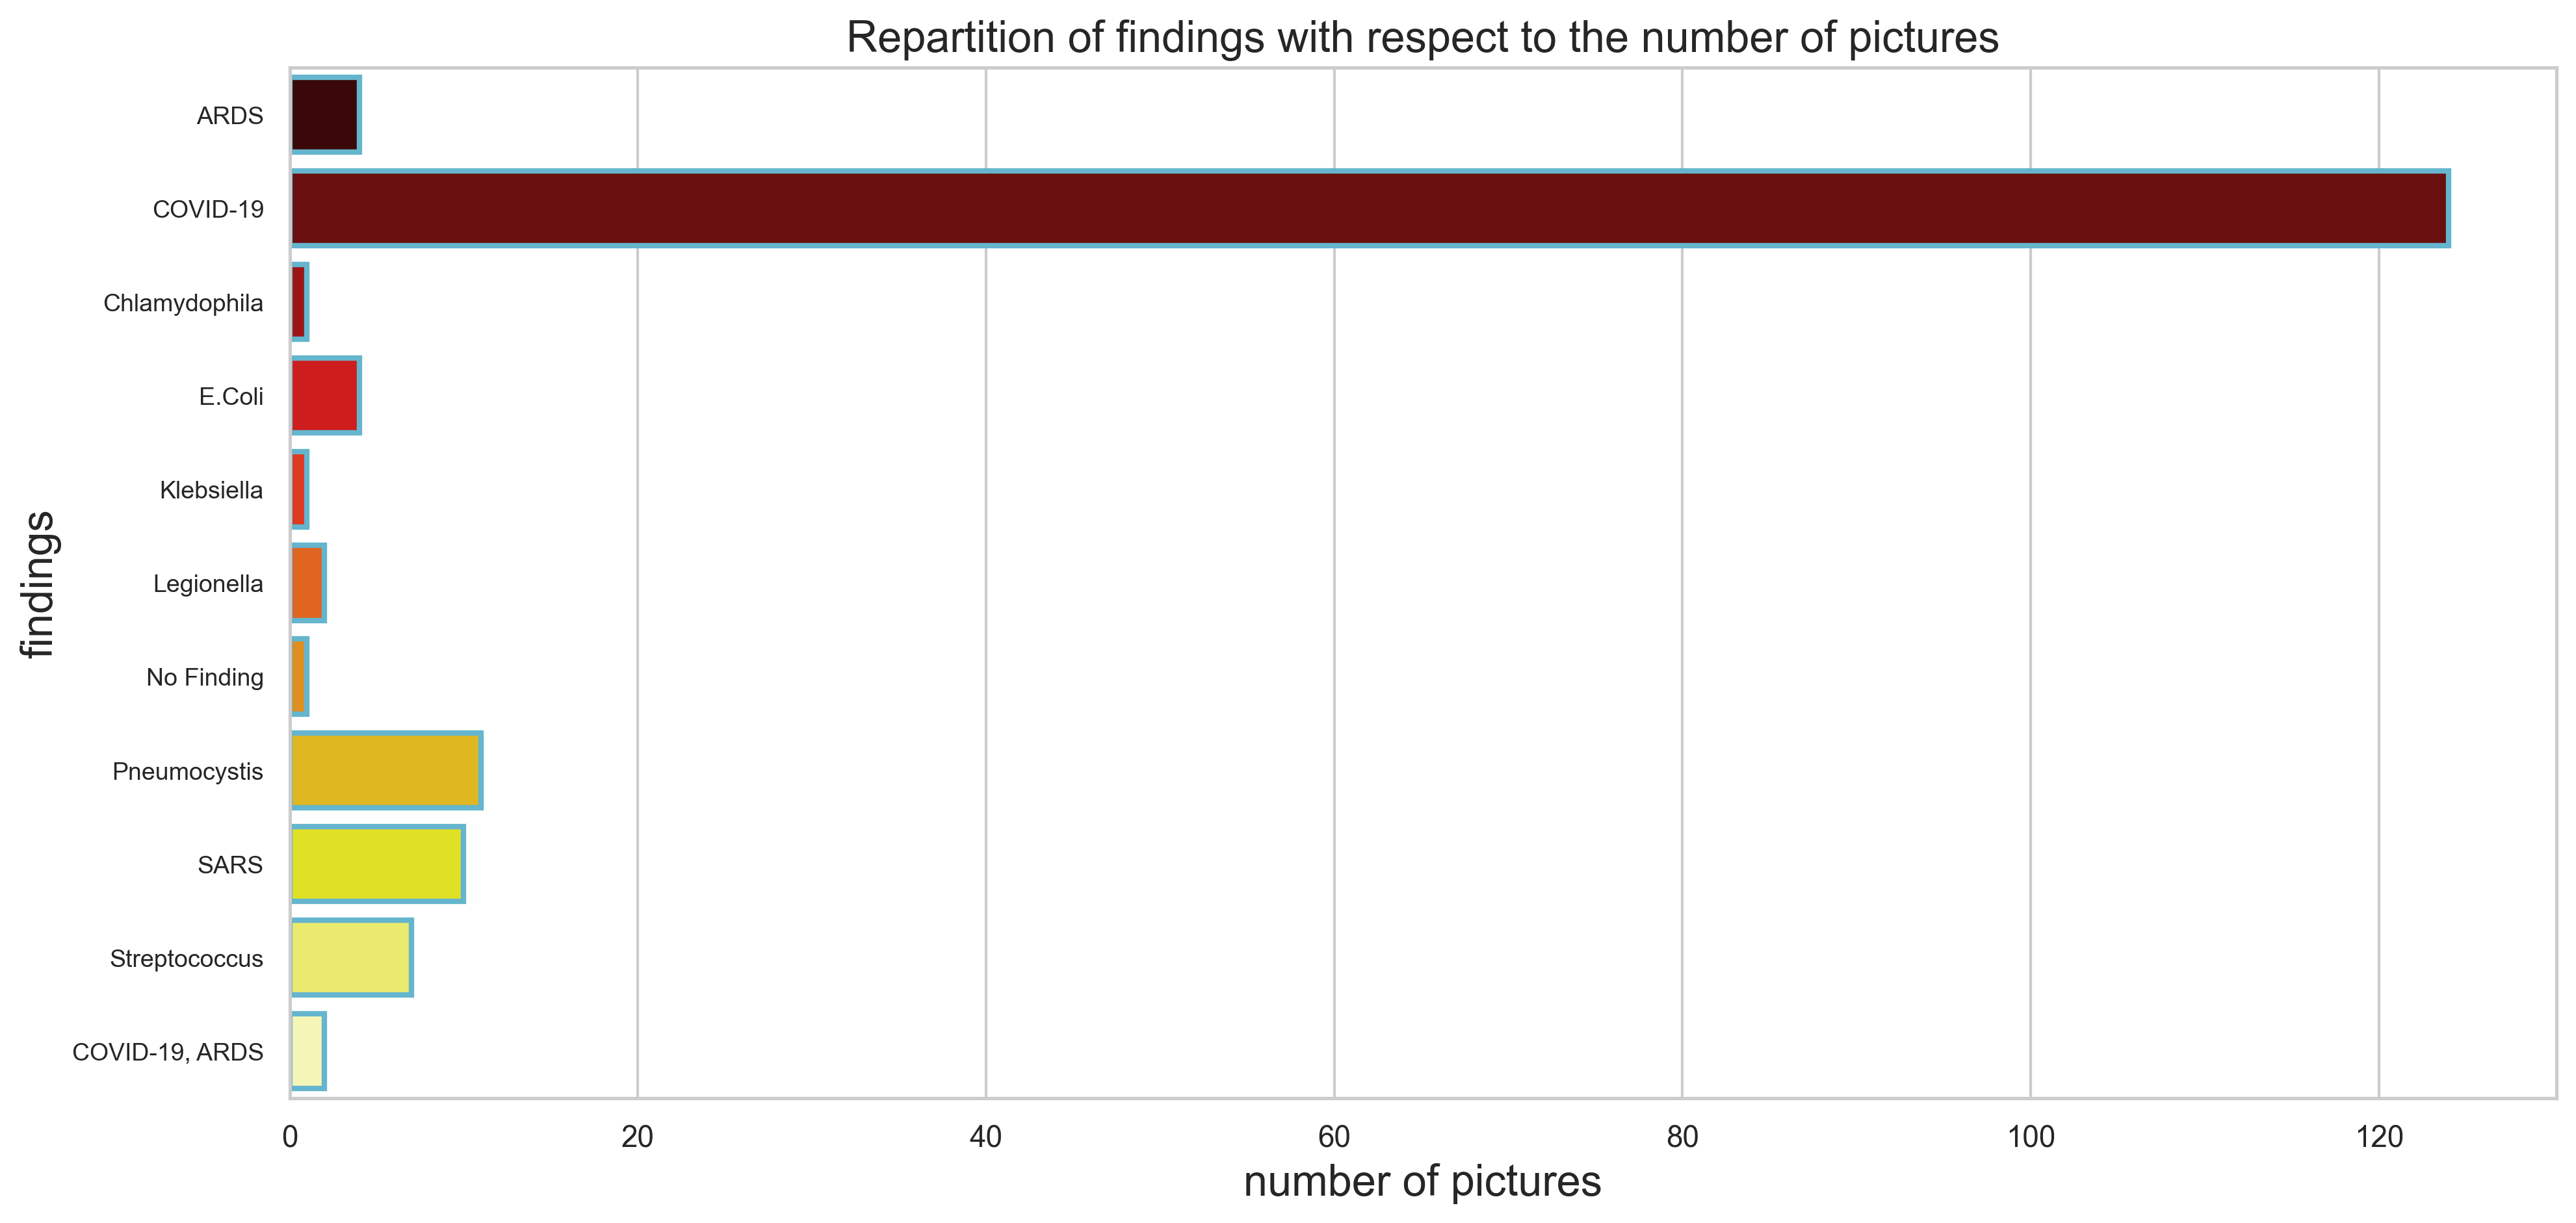

In [13]:
from collections import Counter
import seaborn as sns


counter = Counter(images.finding)
x = list(counter.keys())
y = list(counter.values())

plot_repartition(x,y,xlabel = 'findings',ylabel = 'number of pictures',
                 title = 'Repartition of findings with respect to the number of pictures',
                yticks = (list(dico_findings.values()),list(dico_findings.keys())))
# covid-19 is predominant so a multi-class classification might not be optimal -> dividing them into covid and else will yield better results

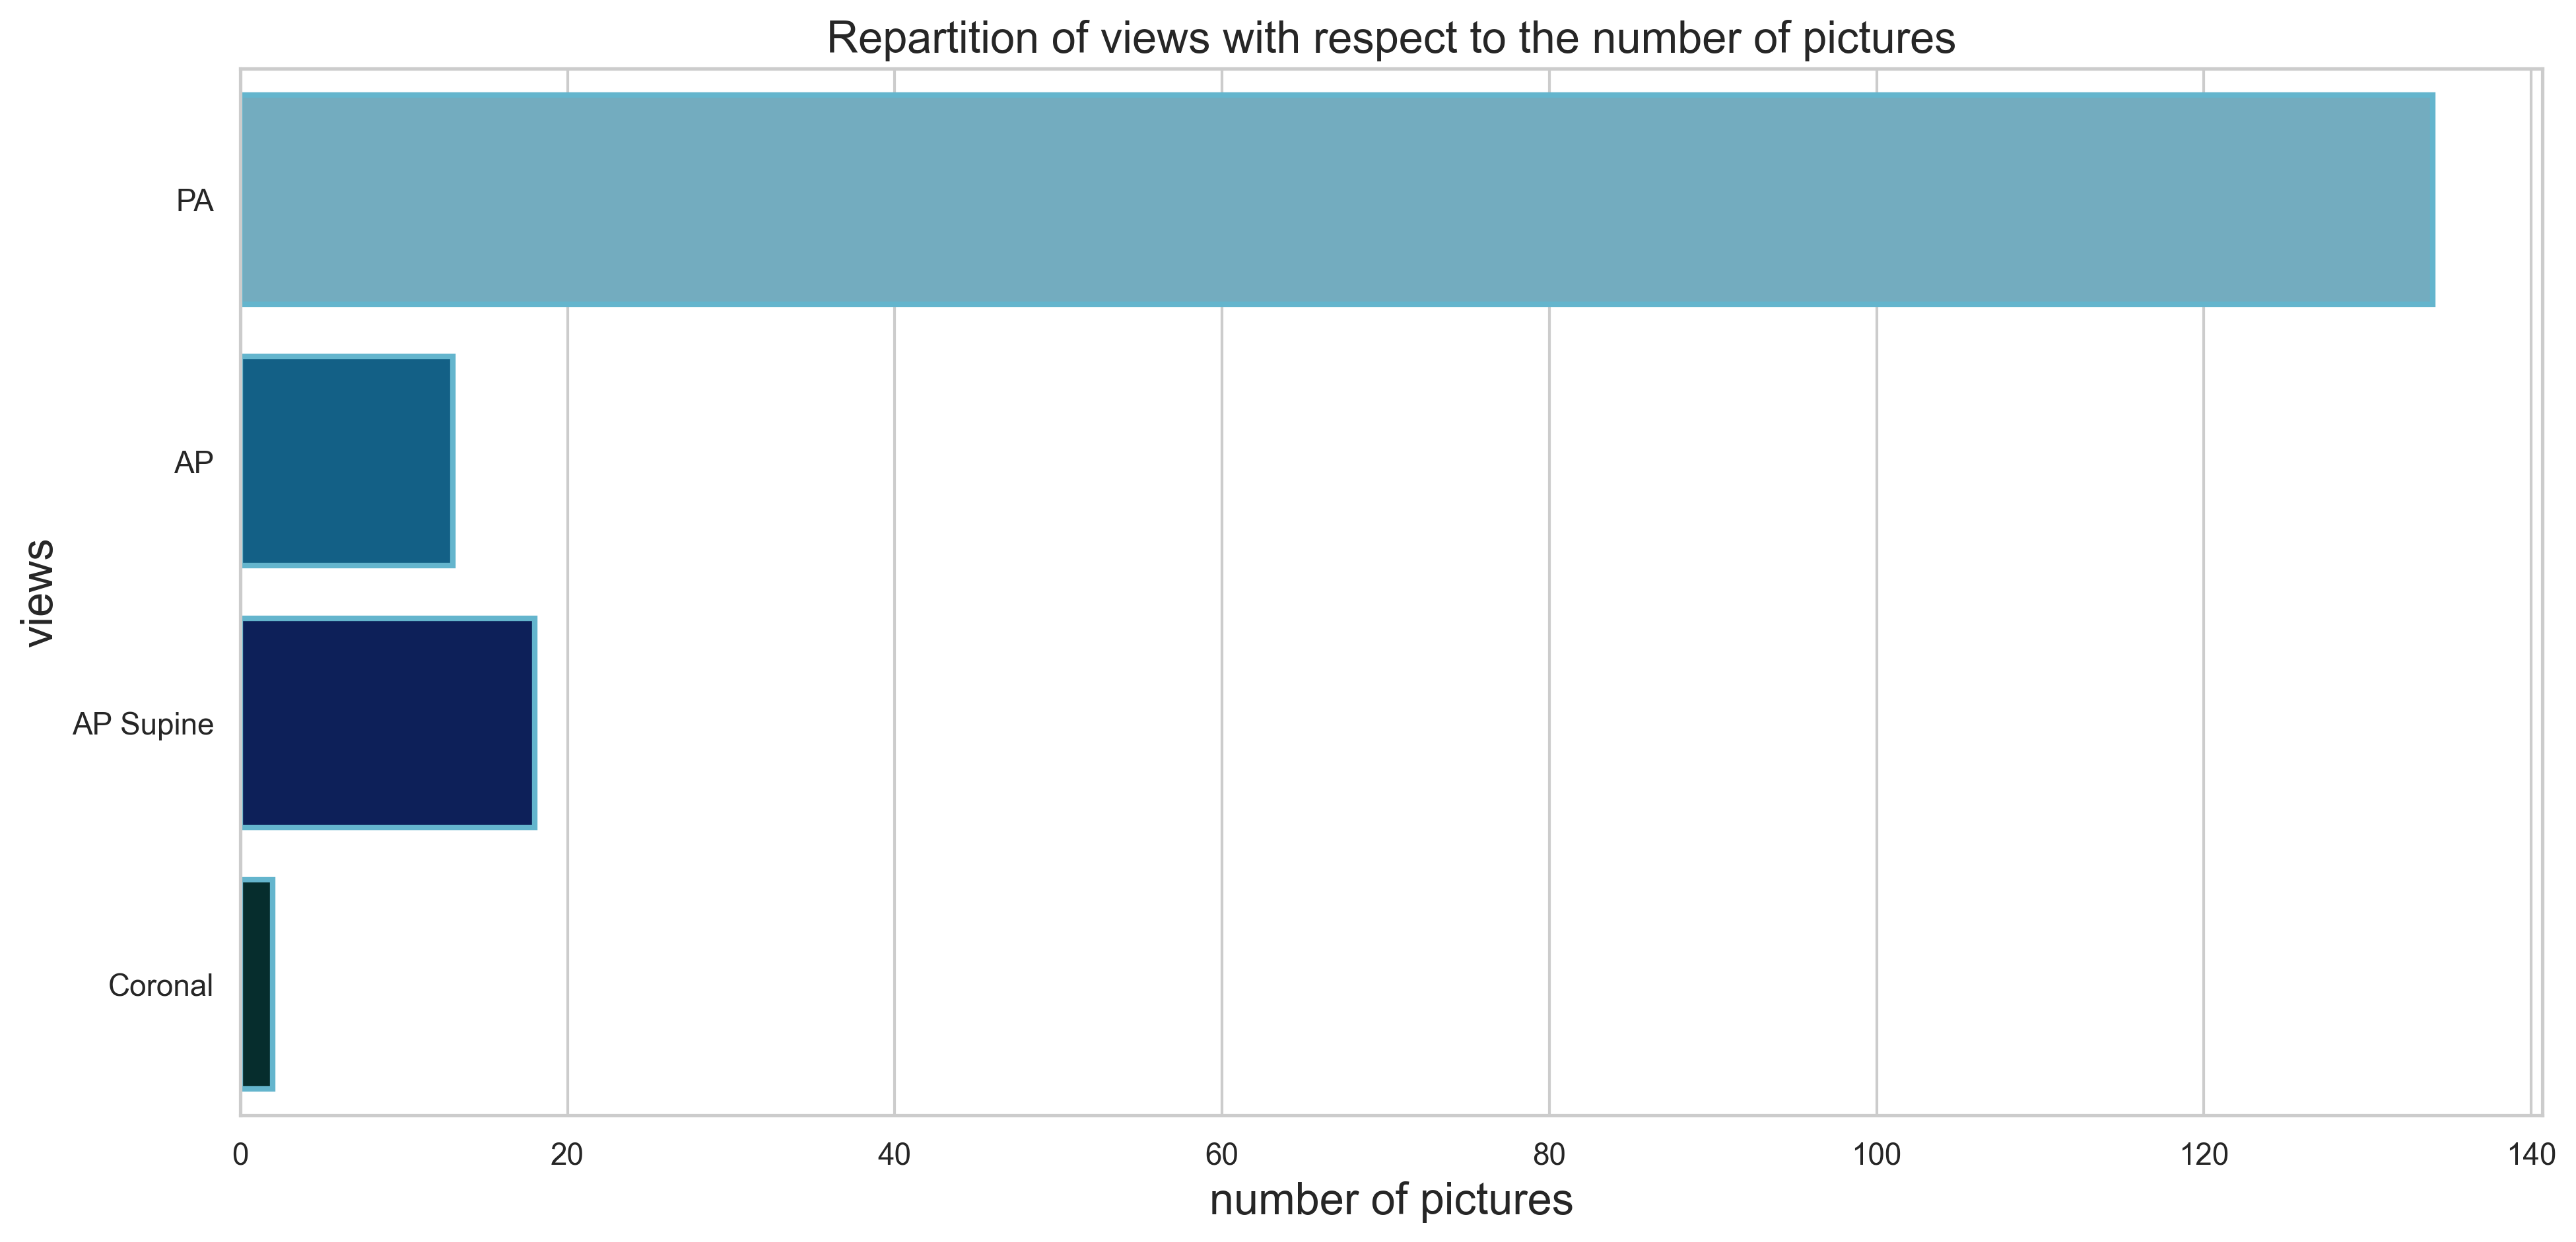

In [14]:
counter = Counter(images.view)
x = list(counter.keys())
y = list(counter.values())

plot_repartition(x,y,'views','number of pictures','Repartition of views with respect to the number of pictures',
                palette = 'ocean_r')

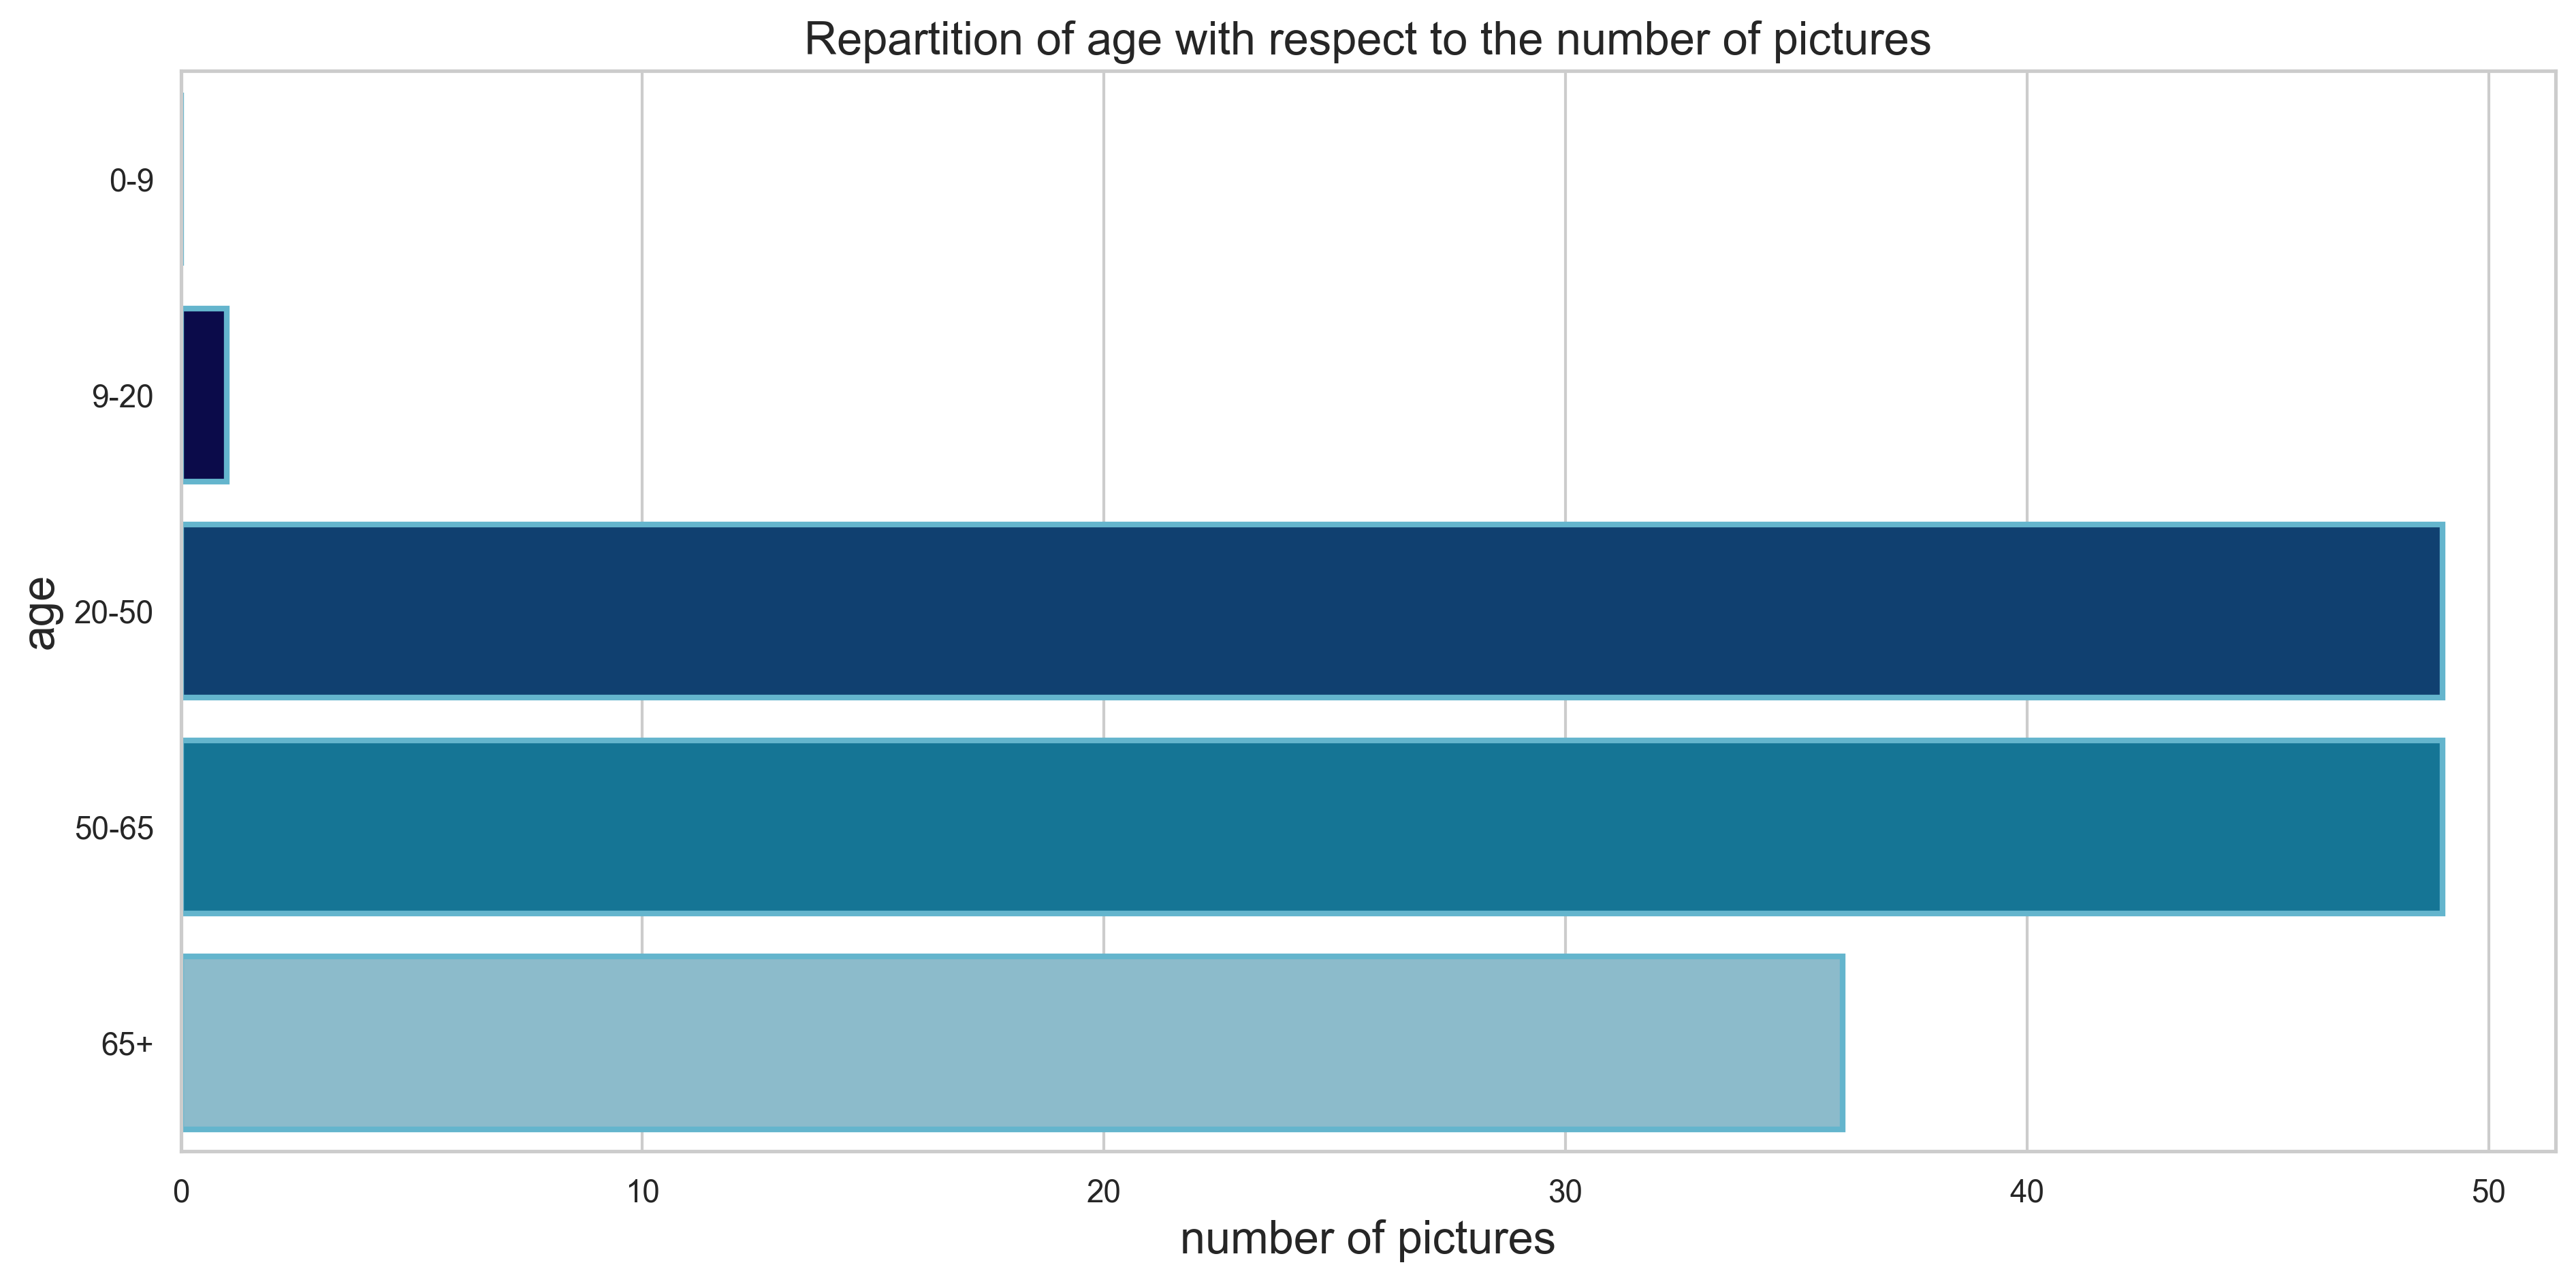

In [15]:

ages = images.age.dropna().astype('int')
tranche_names = ['0-9','9-20','20-50','50-65','65+']
tranche = []
tranche.append(len(ages[ages >0][ages <=9]))
tranche.append(len(ages[ages >9][ages <=20]))
tranche.append(len(ages[ages >20][ages <=50]))
tranche.append(len(ages[ages >50][ages <=65]))
tranche.append(len(ages[ages >65]))
y,x = tranche,tranche_names

plot_repartition(x,y,'age','number of pictures','Repartition of age with respect to the number of pictures',
                palette = 'ocean')

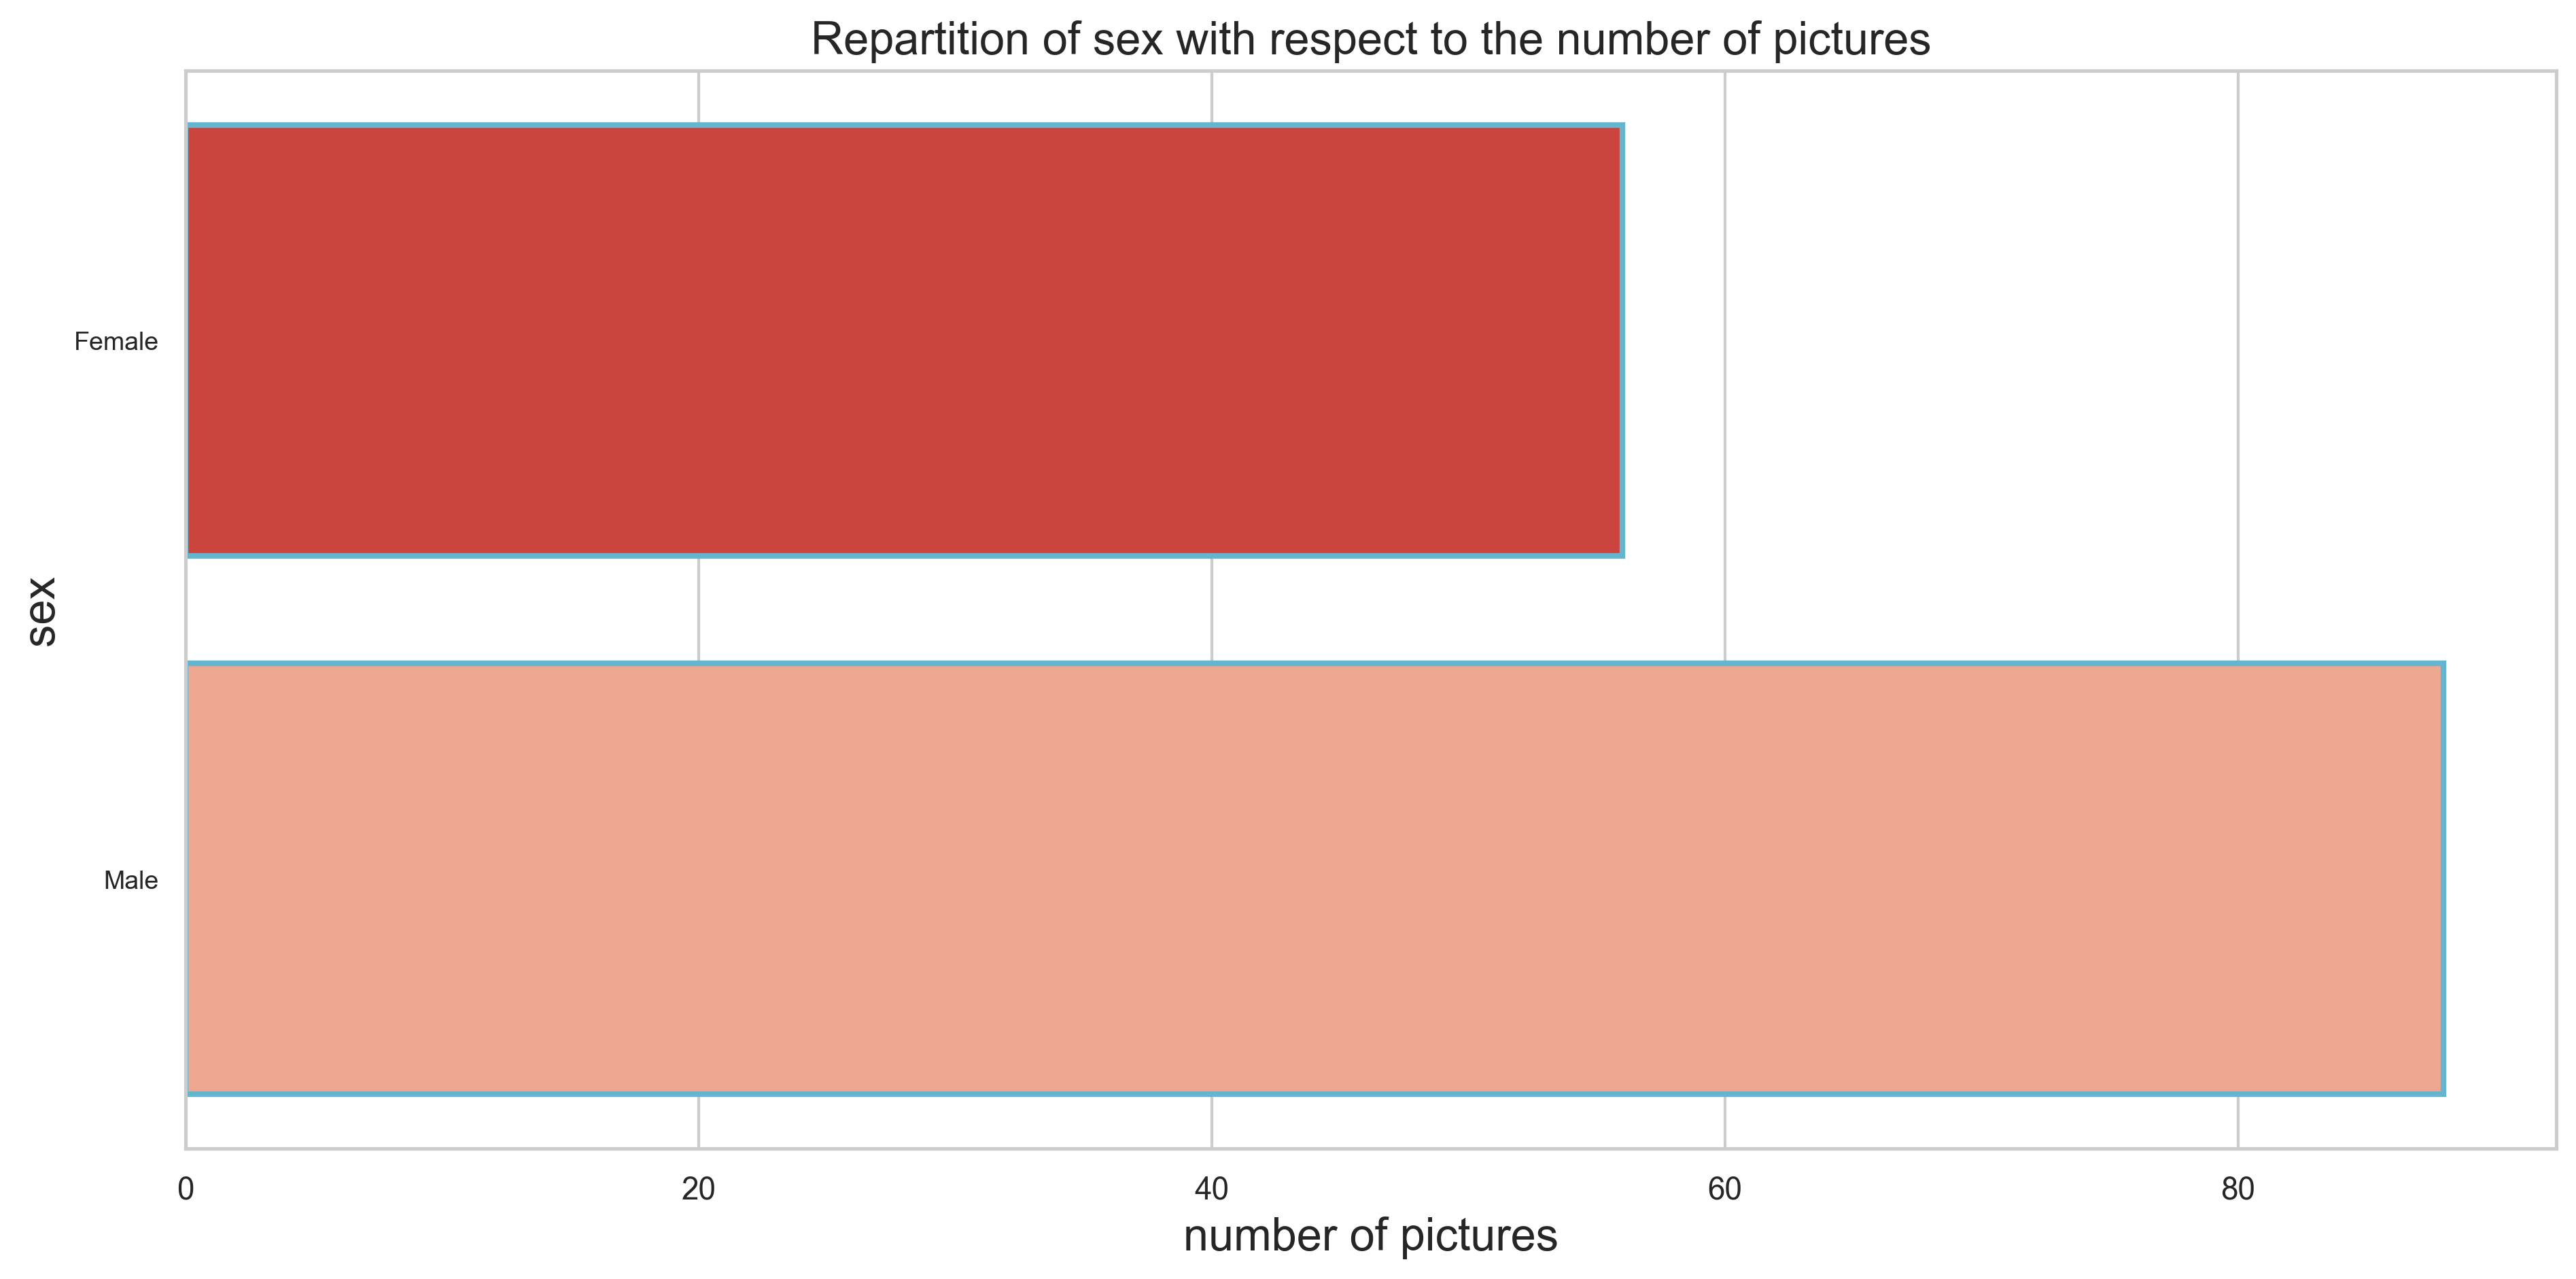

In [16]:
counter = Counter(images.sex)
x = list(counter.keys())
y = list(counter.values())

plot_repartition(x,y,'sex','number of pictures','Repartition of sex with respect to the number of pictures',
                palette = 'Reds_r',yticks = ([0,1],['Female','Male']))

In [17]:
boo = (np.unique(np.c_[images.height,images.width],axis=1).shape == np.c_[images.height,images.width].shape)
print(f'every height x width value is unique : {boo}') 
print(f'number of distinct patients : {len(set(images.patientid))}')

every height x width value is unique : True
number of distinct patients : 111


In [18]:
annotations.head(5) # has almost the same info as the images dataset.

,segmentation,area,image_id,bbox,id,category_id,attributes
0,[],123480.0,1,"[42, 72, 245, 504]",1,1,"{'Finding': ['COVID-19'], 'Modality': ['X-Ray'..."
1,[],221364.0,1,"[380, 12, 468, 473]",2,2,"{'Finding': ['COVID-19'], 'Modality': ['X-Ray'..."
2,[],165135.0,2,"[12, 93, 303, 545]",3,1,"{'Finding': ['COVID-19'], 'Modality': ['X-Ray'..."
3,[],231494.0,2,"[452, 59, 409, 566]",4,2,"{'Finding': ['COVID-19'], 'Modality': ['X-Ray'..."
4,[],257904.0,3,"[23, 73, 432, 597]",5,1,"{'Finding': ['COVID-19'], 'Modality': ['X-Ray'..."


# Conclusions taken from Dataset 1:
1- We have 4 different views. Since "Coronal" looks different from the other 3 views and  only has 2 pictures, we decided to discard "Coronal".

2- We have 2 different modalities, x-rays and CT scans. Considering the fact that we only have two of the CT scans, we discarded the CT scans.

3- By now, most of the x-rays are from covid-19, so we have to find more data, or split the data into covid and non-covid. 

4- Most pictures are from male adults.

5- We have 167 pictures from 111 patients.

6- Each image has different width and height so we should find a way to arrange them into one and unique size.



# Data Preprocessing of Dataset 1

In [19]:
from matplotlib.image import imread
# removing the coronal view and the CT scans // we will have 165 X-rays left
images = images[images.view != 'Coronal']
images = images[images.modality == 0]

directory = './images/'
X = []
y = []
# images in X and the labels in y
for file_name,label in zip(images.file_name, images.finding):
    image  = imread(directory+file_name)
    X.append(image)
    y.append(label)

X = np.array(X) 
y = np.array(y)

In [20]:
# resizing the pictures to the smallest  image shape.
import cv2
min_size = tuple(np.min(np.c_[images.height,images.width], axis=0))
X_resD = []
for xx in X: 
    X_resD.append( cv2.resize(xx,min_size) )



In [21]:
# converting images to GRAYSCALE
from skimage.color import rgba2rgb
from skimage.color import rgb2gray
X_gray=[]
for i in X_resD:
    if i.shape[-1]==4:
        grayimg=rgb2gray(rgba2rgb(i))
        X_gray.append(grayimg)
        continue
    if i.shape[-1]==3:
        grayimg=rgb2gray(i)
        X_gray.append(grayimg)
        continue
    else:
        X_gray.append(i)
        
GRAYS=np.array(X_gray)
y_grays=y

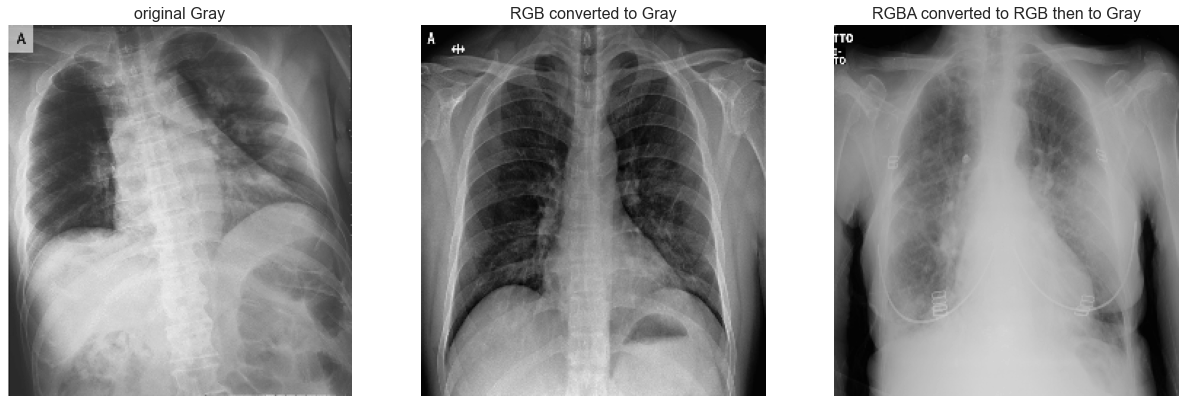

In [22]:
# plotting one image from each channel and converting them to grayscale 
def plot_each_channel(*image,title):
    '''
    image : numpy array of an image
    title : list of titles
    ploting images (3 per row)
    '''
    nbr_ = len(image)
    plt.figure(figsize = (7*nbr_, 7*nbr_))
    for image,nbr in zip(image,range(nbr_)):
        plt.subplot(nbr_//2+1,3,nbr+1)
        plt.imshow(image,cmap = 'gray')
        plt.axis('off')
        plt.title(f'{title[nbr]}',size = 16)
        
plot_each_channel(GRAYS[0], GRAYS[24], GRAYS[-1], title = ['original Gray', 'RGB converted to Gray', 
                                                   'RGBA converted to RGB then to Gray'] )

In [23]:
n_samples = GRAYS.shape[0]
height = GRAYS.shape[1]
width = GRAYS.shape[2]
print(f'in total we have {n_samples} grayscale images with shape ({height}x{width})')

in total we have 165 grayscale images with shape (255x237)


# Dataset 2 - Extraction and preprocessing 
A good classification requires more data so we will merge two datasets. The second has three classes : healthy xrays, Covid-19 xrays, and viral pneumonia xrays 

In [24]:
# getting the data out
normal = pd.read_excel(directory_met +'NORMAL.metadata.xlsx')
pneumonia = pd.read_excel(directory_met +'Viral Pneumonia.metadata.xlsx')
covid = pd.read_excel(directory_met +'COVID-19.metadata.xlsx')

# making them match the filenames
covid['FILE NAME'].replace(' *\(',' (',regex = True, inplace = True)
covid['FILE NAME'][133:].replace(' *\(','(',regex = True, inplace = True)
normal['FILE NAME'].replace(' *-',' (',regex = True, inplace = True)
pneumonia['FILE NAME'].replace(' *\-',' (',regex = True, inplace = True)

def image_extraction(df,out,directory,ext = '.png', min_size = min_size,replacement = True):
    '''
    getting the images from file and storing them
    in an array called out
    '''
    globals()[out] = []
    
    for filename in (df['FILE NAME']):
        if replacement:
            filename = filename + ')'
        image = imread(directory + filename + ext)
        image=rgb2gray(image)
        globals()[out].append( np.array(cv2.resize(image,min_size)) )
    print(out, True)

image_extraction(normal,'normal_im','./all_new_images/')
image_extraction(covid,'covid_im','./all_new_images/',replacement = False)
image_extraction(pneumonia,'pneumonia_im','./all_new_images/')

covid_im=np.array(covid_im)
normal_im=np.array(normal_im)
pneumonia_im=np.array(pneumonia_im)

normal_im True
covid_im True
pneumonia_im True


In [25]:
dico_findings # legend for the labels

{'ARDS': 0,
 'COVID-19': 1,
 'Chlamydophila': 2,
 'E.Coli': 3,
 'Klebsiella': 4,
 'Legionella': 5,
 'No Finding': 6,
 'Pneumocystis': 7,
 'SARS': 8,
 'Streptococcus': 9,
 'COVID-19, ARDS': 10}

In [26]:
# creating y_values for covid_im and pneumonia_im and adding them to GRAYS and y_grays
y_covid = np.ones(covid_im.shape[0])
y_pneumonia = np.ones(pneumonia_im.shape[0]) * 11 # 11 will represent pneumonia
y_normal = np.ones(normal_im.shape[0]) * 6 # normal is the equivalent of no finding

X_final = np.array(list(GRAYS) + list(covid_im ) + list(pneumonia_im) + list(normal_im) )

y_final = np.array(list(y_grays) + list(y_covid ) + list(y_pneumonia) + list(y_normal) , dtype = 'int')

# CNN models

With the goal of maximizing the recall and  accuracy because it is a metric that shows us how accuratly we are labeling covid-positive people. Accuratly labeling covid-positive patients is more important than correctly labeling covid-Negative patient.

In [27]:
# Changing the labels into 1 and 0, 1 for covid and 0 for else

labels_bin = list(y_final)
for count,i in enumerate(y_final):
    if i ==10:
        labels_bin[count] = 1
    elif i !=1:
        labels_bin[count] = 0
# but still have more images of covid compared to the rest. SMOTE will be used for oversampling later on.


In [28]:
def One_hot_encoding(y,val):
    '''
    val : int
    y : list or numpy array
    returns one hot encoded array of y
    '''
    y = np.array(y)
    vec = np.zeros((y.shape[0],val))
    
    for count,i in enumerate(y):
        temp = np.zeros(val)
        temp[i] = 1
        vec[count] = temp
    return vec

y_bin = One_hot_encoding(labels_bin,2)

In [29]:
def correct_labeling(model,X_test,X_train):
    '''
    returns the number of correctly labeled images from the test and training data
    '''
    y_pred = model.predict(X_test)
    n_correct = np.sum(np.argmax(y_pred,1) == np.argmax(y_test,1))
    total = len(np.argmax(y_test,1))

    print(f'got a total of {n_correct} correct labeling out of {total} for the test data') 

    y_pred = model.predict(X_train)
    n_correct = np.sum(np.argmax(y_pred,1) == np.argmax(y_train,1))
    total = len(np.argmax(y_train,1))

    print(f'got a total of {n_correct} correct labeling out of {total} for the training data')

In [30]:
from sklearn.metrics import accuracy_score, recall_score, log_loss
def metrics(model):
    '''
    prints accuracy, loss, recall, and precision of unseen test data
    '''
    y_pred = np.argmax(model.predict(X_test),1)
    val_loss = log_loss(np.argmax(y_test,1),y_pred)
    val_acc = accuracy_score(np.argmax(y_test,1),y_pred)
    recall = recall_score(np.argmax(y_test,1),y_pred)
    print(f'accuracy : {round(val_acc,2)} / loss: {round(val_loss,2)} / recall : {round(recall,2)}')

In [31]:
def ploting_history(history,keys, ylabel,labels = ['test','training'] ,epochs = 10,reverse = True):
    '''
    ploting history for the given keys in order, 2 by 2 
    history : dictionary from json file
    '''
    num = len(keys)
    sub = 0 
    dico = history
    plt.figure(figsize = (7*num, 7* num))
    for key,ylabel in zip(keys,ylabel):
        sub+=1
        if reverse:
            plt.subplot(num,2,sub)
        else:
            plt.subplot(num,1,sub)
        plt.plot(np.arange(1,epochs+1), list(dico[key[0]].values()),label = key[0] )
        plt.plot(np.arange(1,epochs+1), list(dico[key[1]].values()), label = key[1])
        title = 'progress of ' + ylabel + ' with respect to the number of epochs'
        plt.title(title,size = 16)
        plt.xlabel('nbr of epochs',size = 16)
        plt.ylabel(ylabel,size = 16)
        plt.legend()
        
    plt.show()

In [32]:
def mask_fun(cm1):
    '''
    return mask of needed rows and columns of confusion matrix
    '''
    
    h0 = np.triu_indices(len(cm1),1)
    mask  = np.zeros(cm1.shape)
    mask[h0] = 1
    mask[0,1] = 0

    h1 = np.tril_indices(len(cm1[2:,2:]),-1)
    mask[2:,2:][h1] = 1
    mask[2:,:1] = 1
    return mask

In [33]:
# Confusion matrix

# PROCEDURE :
# y_bin is an ordered version of y_final (with 1 : positive to covid and 0: negative to covid), so by comparing it to y_final, we can tell when a finding was mislabeled as covid
# to do that we will loop over y_bin_pred and change every instance of 0 with it's value in y_final ***if it's not 1*** (so that the wrong 0s won't be turned to the correct value.), and leave the 1s unchanged
# then we will make a confusion matrix on the updated y_bin_pred and y_final

# WARNING : THE MODEL ONLY KNOWS HOW TO CLASSIFY COVID/NON-COVID.

# the shape of the CM will be odd looking. it has to do with the procedure mentioned above, and it should only be 
# used to tell what findings are usually mistaken for COVID.

# if you want to turn the mask off, you can set the parameter M to False, which will give you a normal looking
# square CM.

def Confusion_m(model,X_final,y_final,dico_findings = dico_findings,M = True):
    '''
    plots the confusion matrix following the procedures above

    '''
    y_bin_pred = np.argmax(model.predict(X_final),1)
    y_pred_updated = np.ones(y_bin_pred.shape,dtype = int)
    for count,i in enumerate(y_bin_pred):
        if i ==0 and y_final[count] !=1 :
            y_pred_updated[count] = y_final[count]
        elif i == 0:
            y_pred_updated[count] = 0
    tick = list(dico_findings.keys())
    tick.append('Pneumonia')
    cm1 = confusion_matrix(y_final,y_pred_updated)
    mask  = np.zeros(cm1.shape)
    if M:
        mask = mask_fun(cm1)
    sns.heatmap(cm1,annot= True,cmap = 'Blues_r',cbar = False,yticklabels = tick,
                xticklabels = tick,fmt = '.0f', mask = mask  )
    plt.xlabel('PREDICTED',size = 16)
    plt.ylabel('TRUE',size = 16)
    plt.show()

In [34]:
# let's import everything we will use here from keras 
import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Conv2D,Dropout,MaxPooling2D
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [35]:
def build_model00():
    model00 = Sequential()
    model00.add(Dense( 50,input_shape = (255,237,1) ))
    model00.add(Flatten())
    model00.add(Dense( 2,activation = 'sigmoid' ))
    
    return model00

In [36]:
#let's start with a simple neural network with just no hidden layer

X_train, X_test, y_train, y_test = train_test_split(X_final,y_bin,test_size = .2,random_state = 42)
X_train = X_train.reshape(X_train.shape[0],255,-1,1)
X_test = X_test.reshape(X_test.shape[0],255,-1,1)

model00 = build_model00()
model00.compile(Adam(lr =.001),loss = 'binary_crossentropy', metrics = [keras.metrics.Recall(),'accuracy'])
#hist00 = model00.fit(X_train,y_train,epochs = 10, batch_size = 10, validation_split = .2)


In [37]:
model00.load_weights('./weights/model00_weights.h5')
metrics(model00)
correct_labeling(model00,X_test = X_test,X_train = X_train)

accuracy : 0.86 / loss: 4.67 / recall : 0.32
got a total of 531 correct labeling out of 614 for the test data
got a total of 2156 correct labeling out of 2456 for the training data


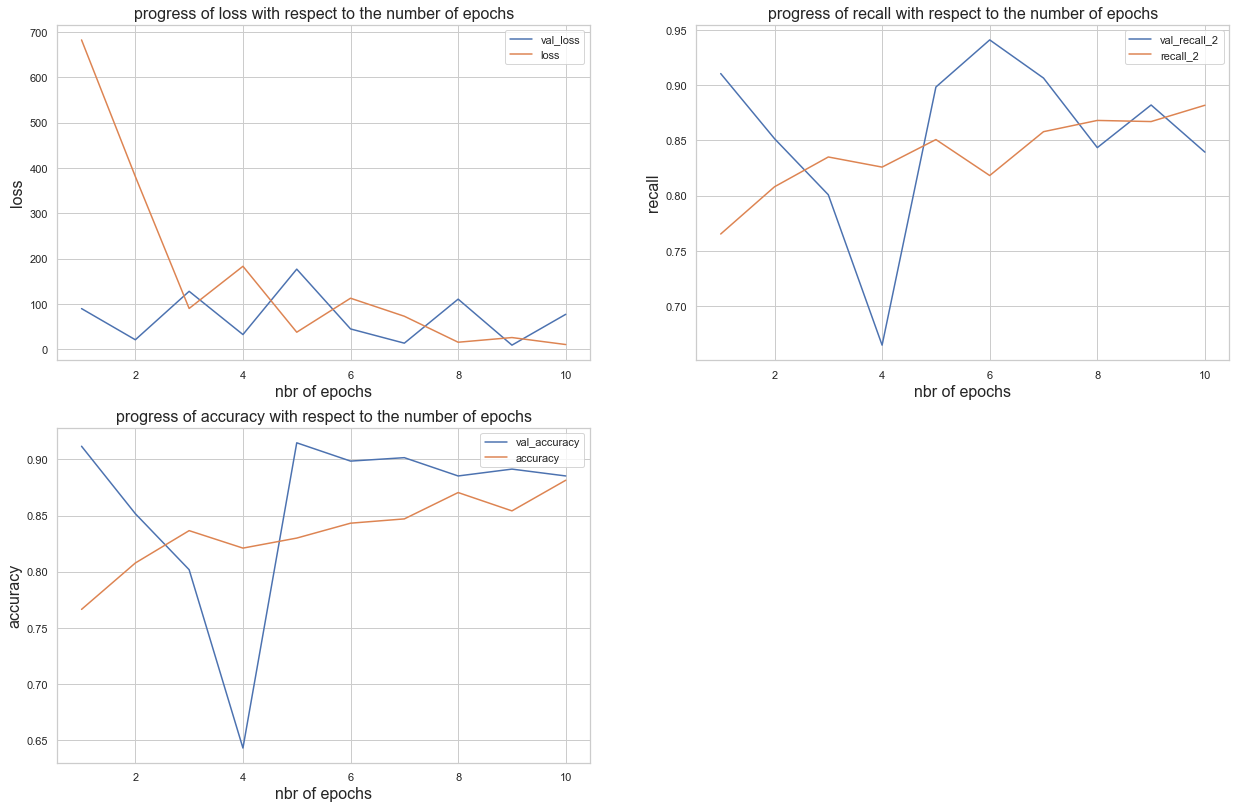

In [38]:
with open('./histories/history00.json','r') as f:
    hist00 = json.load(f)
ploting_history(hist00,[['val_loss','loss'], ['val_recall_2','recall_2'], ['val_accuracy','accuracy']], 
                ylabel = ['loss','recall','accuracy'],epochs =10)

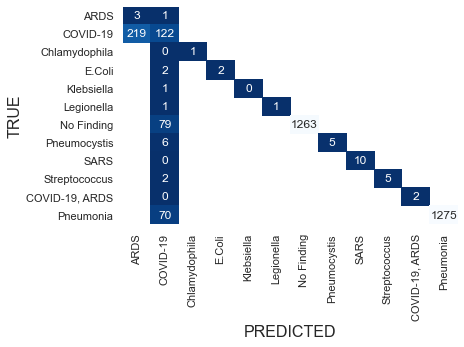

In [39]:
Confusion_m(model00,X_final.reshape(-1,255,237,1),y_final,dico_findings = dico_findings)

# Limitations of the model:

1- the number of non-covid pictures surpass its counterpart so if we use a model more complex than model00, the model will tend to turn every prediction to 0 becayse it is maximizing the accuracy.

2-We don't have enough data for *E.coli, Streptococcus, and SARS*, and because most of their pictures were mislabeled as covid-19, theoretically if we had more testing data (not training) those three findings will have a higher chance of getting mislabeled as covid-19.

3-Covid-19 is usually mislabeled as ARDS, but ARDS is not.

#### To tackle the first limitation, SMOTE will be used. It will enable the use of more complex models without falling into the trap of turning every prediction to 0(covid-negative).

In [40]:
from imblearn.over_sampling import SMOTE
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization

In [41]:
def build_model01():
    model01 = Sequential()
    model01.add(Conv2D( 50, (3,3),input_shape = (255,237,1) , activation = LeakyReLU(.2)))
    model01.add(BatchNormalization())
    model01.add(Dropout(.2))
    model01.add(Flatten())
    model01.add(Dense( 2,activation = 'sigmoid' ))
    
    return model01

In [42]:
# using a more complex model 

X_train, X_test, y_train, y_test = train_test_split(X_final,y_bin,test_size = .2,random_state = 42)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train.reshape(-1,255*237), y_train)

X_train = X_train.reshape(X_train.shape[0],255,-1,1)
X_test = X_test.reshape(X_test.shape[0],255,-1,1)

y_train = One_hot_encoding(y_train,2)

model01 = build_model01()
model01.compile(Adam(lr =.0001),loss = 'binary_crossentropy', metrics = [keras.metrics.Recall(),'accuracy'])

#hist01 = model01.fit(X_train,y_train,epochs = 10, batch_size = 10, validation_split = .2)

In [43]:
model01.load_weights('./weights/model01_weights.h5')
metrics(model01)
correct_labeling(model01,X_test = X_test,X_train = X_train)

accuracy : 0.98 / loss: 0.84 / recall : 0.85
got a total of 599 correct labeling out of 614 for the test data
got a total of 4366 correct labeling out of 4386 for the training data


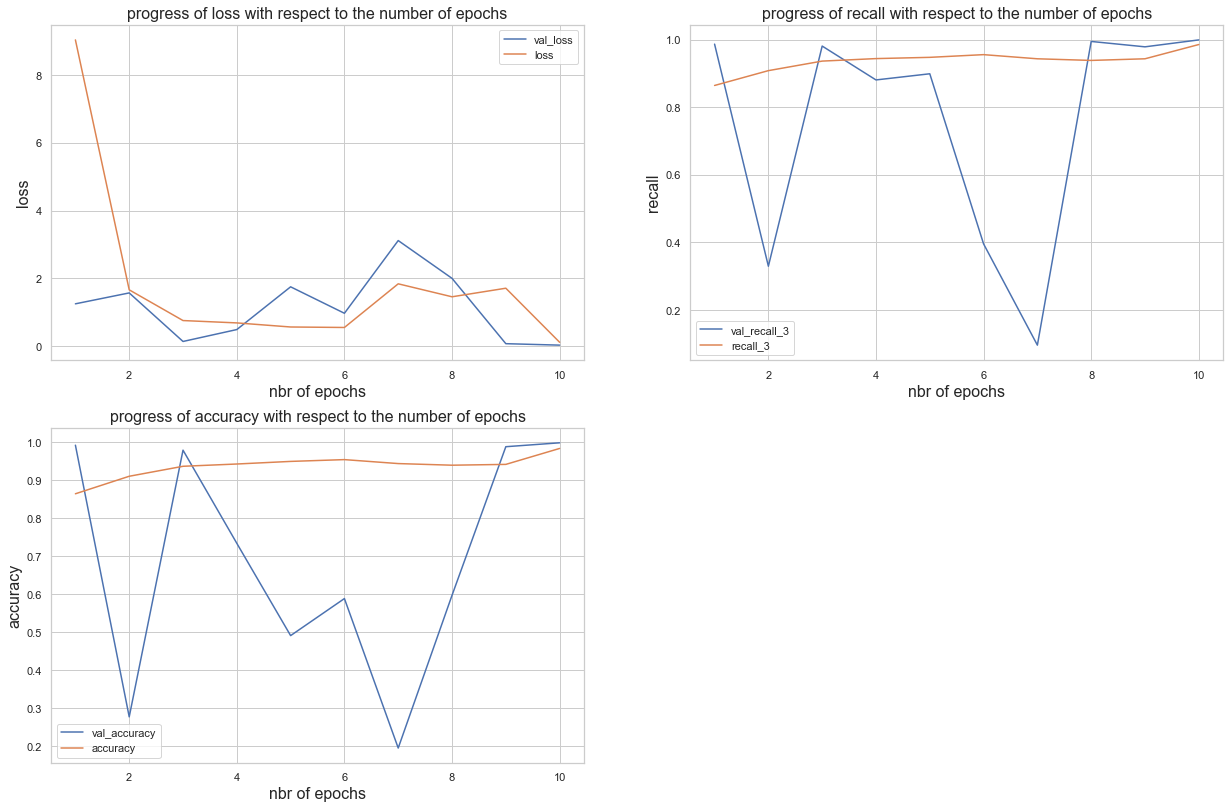

In [44]:
with open('./histories/history01.json','r') as f:
    hist01 = json.load(f)
ploting_history(hist01,[['val_loss','loss'], ['val_recall_3','recall_3'], ['val_accuracy','accuracy']], ylabel = ['loss','recall','accuracy'],
               reverse = True)

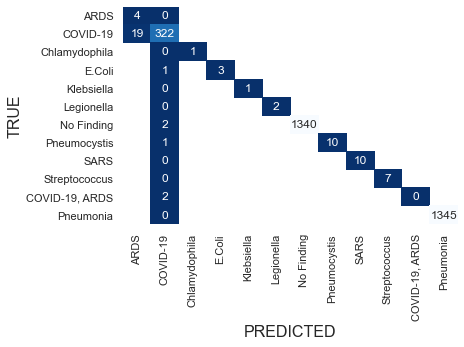

In [45]:
Confusion_m(model01,X_final.reshape(X_final.shape[0],255,-1,1),y_final)

In [46]:
# adding early stopping and more hidden layers to improve the Recall
def build_model02():
    model02 = Sequential()
    model02.add(Conv2D( 32,(3,3),input_shape = (X_train.shape[1],X_train.shape[2],1), activation = LeakyReLU(.2) ))
    model02.add(Dropout(.25))
    model02.add(MaxPooling2D(3,3))
    model02.add(Conv2D( 64,(3,3), activation = LeakyReLU(.2) ))
    model02.add(Dropout(.25))
    model02.add(MaxPooling2D(3,3))
    model02.add(Conv2D( 128,(3,3), activation = LeakyReLU(.2) ))
    model02.add(Dropout(.25))
    model02.add(MaxPooling2D(3,3))
    model02.add(Flatten())
    model02.add(Dense( 2,activation = 'sigmoid' ))
    
    return model02

In [47]:

from keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(X_final,y_bin,test_size = .2,random_state = 42)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train.reshape(-1,255*237), y_train)

X_train = X_train.reshape(X_train.shape[0],255,-1,1)
X_test = X_test.reshape(X_test.shape[0],255,-1,1)

y_train = One_hot_encoding(y_train,2)

eas = EarlyStopping(monitor = 'val_recall_2', patience = 3)

model02 = build_model02()

model02.compile(Adam(lr =.001),loss = 'binary_crossentropy', metrics = [keras.metrics.Recall()])

#hist02 = model02.fit(X_train,y_train,epochs = 10,batch_size = 10, validation_split = .2, callbacks = [eas])

In [48]:
model02.load_weights('./weights/model02_weights.h5')
metrics(model02)
correct_labeling(model02,X_test = X_test,X_train = X_train)

accuracy : 0.95 / loss: 1.69 / recall : 0.92
got a total of 584 correct labeling out of 614 for the test data
got a total of 4179 correct labeling out of 4386 for the training data


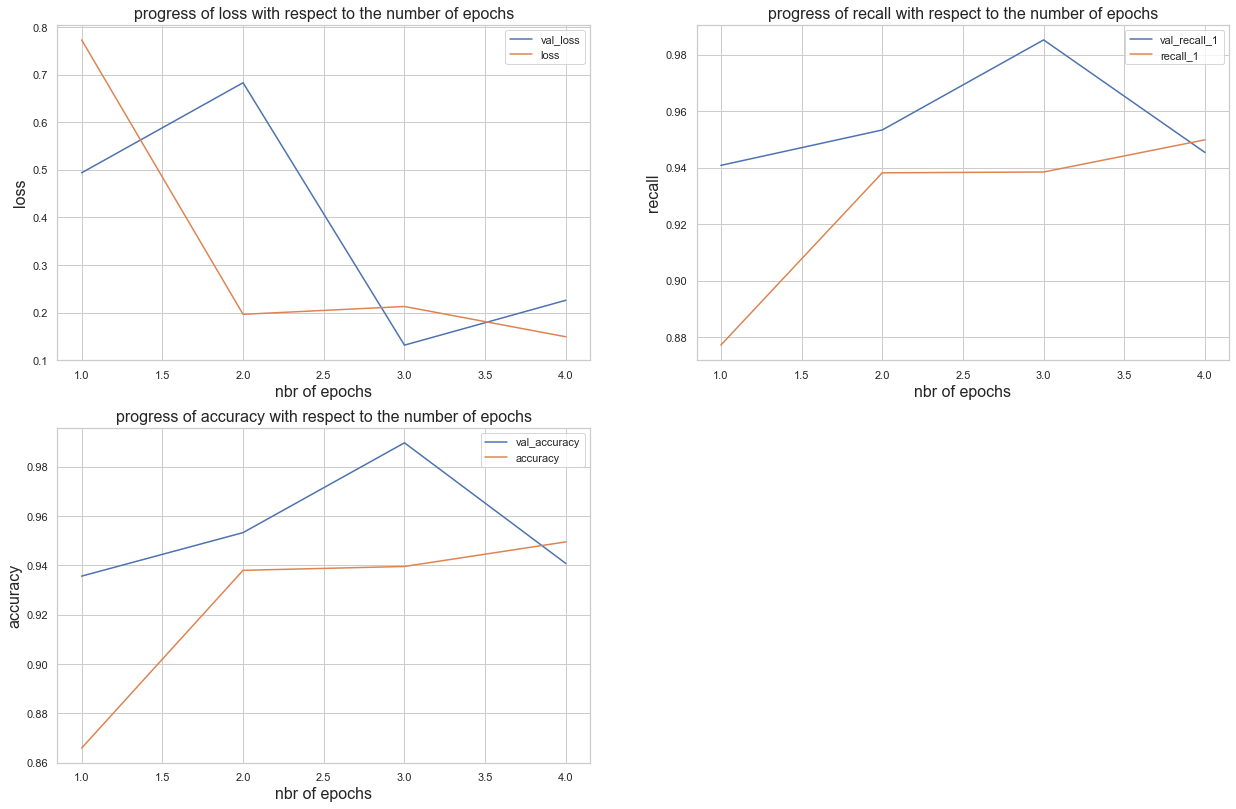

In [49]:
with open('./histories/history02.json','r') as f:
    hist02 = json.load(f)
ploting_history(hist02,[['val_loss','loss'], ['val_recall_1','recall_1'], ['val_accuracy','accuracy']], ylabel = ['loss','recall','accuracy'],
               reverse = True,epochs = 4)

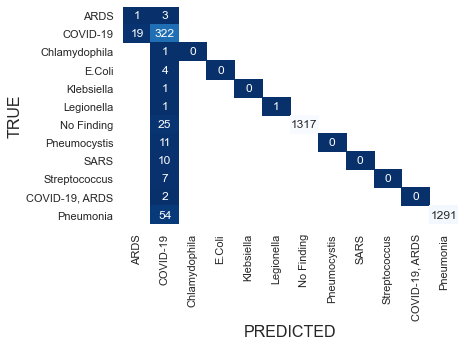

In [50]:
Confusion_m(model02,X_final.reshape(X_final.shape[0],255,-1,1),y_final)

# checking validity of model02

In [51]:
# to make sure that the model is not biased, (because it can reach a high accuracy by turning everything to 0), we
# will take unseen data and select covid positive pictures only and see how well does it label them. if it 
# recognizes most of the pictures as covid positive we can assume that our model is not biased and works well.
tes = model02.predict(X_test[np.argmax(y_test,1) == 1].reshape(-1,255,237,1))
print(f'number of correct labeling {np.sum(np.argmax(tes,1) == 1)} out of {len(tes)}')
# it doesn't look biased.

number of correct labeling 74 out of 80


With the random forest classifier (below), the model was strangely only taking into consideration the borders of the images. We are not sure if the model02 suffers from the same problem, so we will be training on a new model with cropped images to further increase recall and accuracy. 

In [52]:
def crop(X):
    cropped = X.reshape(-1,X.shape[1],X.shape[2])[:,:,20:-20] # cropped images (kind of zoomed in you can see an example below)
    return np.array(cropped)


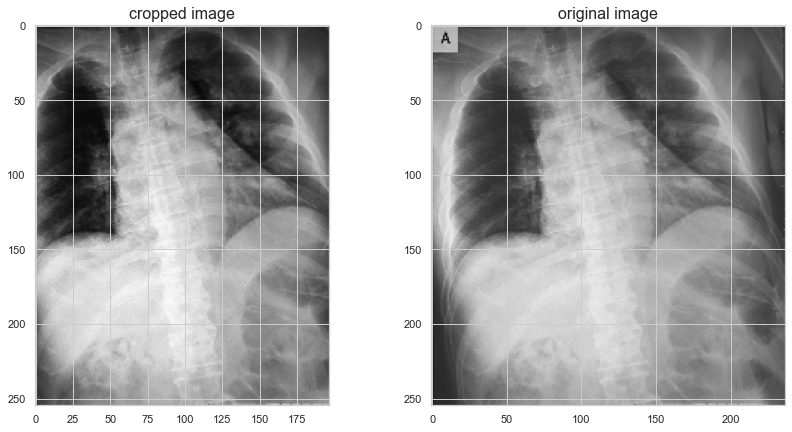

In [53]:
#comparison of the two images
img_num = -100
plt.figure(figsize = (14,7))
plt.subplot(1,2,1)
plt.imshow( crop(X_final)[0], cmap = 'gray' )
plt.title('cropped image', size = 16)
plt.subplot(1,2,2)
plt.imshow( X_final[0].reshape(255,237), cmap = 'gray' )
plt.title('original image', size = 16)
plt.show()

In [54]:
# Training model03 on cropped xray images 
X_train, X_test, y_train, y_test = train_test_split(X_final,y_bin,test_size = .2,random_state = 42)

# cropping the images
X_train = crop(X_train) 
X_test = crop(X_test)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train.reshape(-1,X_train.shape[1]*X_train.shape[2]), y_train)

X_train = X_train.reshape(X_train.shape[0],255,-1,1)
X_test = X_test.reshape(X_test.shape[0],255,-1,1)

y_train = One_hot_encoding(y_train,2)

In [55]:

from keras.layers.advanced_activations import LeakyReLU

eas = EarlyStopping(monitor = 'val_recall_4', patience = 3)

model03 = build_model02() # same as model02 but trains on cropped images

model03.compile(Adam(lr =.0001),loss = 'binary_crossentropy', metrics = [keras.metrics.Recall()])

#hist03 = model03.fit(X_train,y_train,epochs = 10,batch_size = 10, validation_split = .2,callbacks = [eas])

In [56]:
model03.load_weights('./weights/model03_weights.h5')
metrics(model03)
correct_labeling(model03,X_train = X_train,X_test = X_test)

accuracy : 0.92 / loss: 2.76 / recall : 0.96
got a total of 565 correct labeling out of 614 for the test data
got a total of 4087 correct labeling out of 4386 for the training data


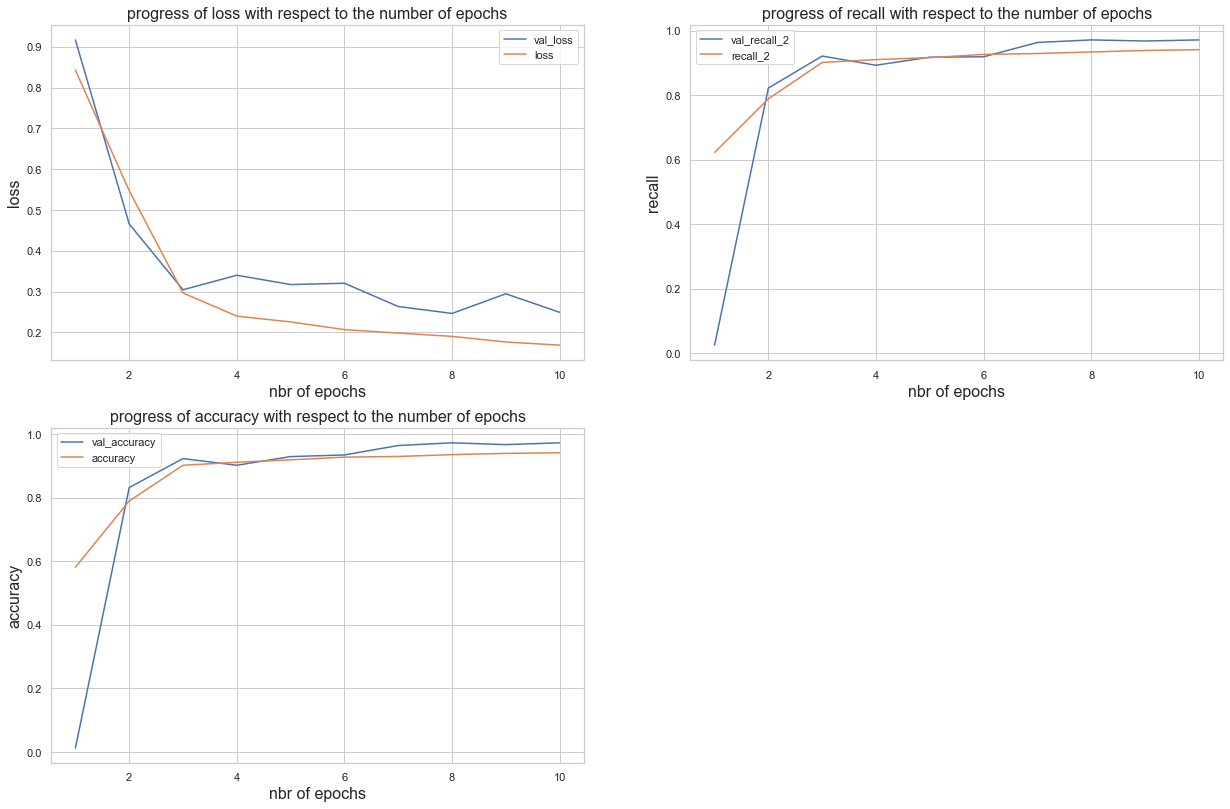

In [57]:
with open('./histories/history03.json','r') as f:
    hist03 = json.load(f)
ploting_history(hist03,[['val_loss','loss'], ['val_recall_2','recall_2'], ['val_accuracy','accuracy']], 
                ylabel = ['loss','recall','accuracy'],reverse = True)

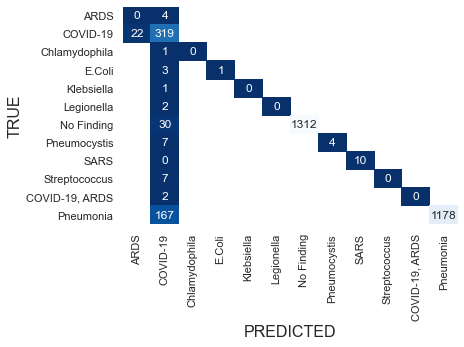

In [58]:
xx = crop(X_final)
Confusion_m(model03,xx.reshape(-1,xx.shape[1],xx.shape[2],1),y_final)

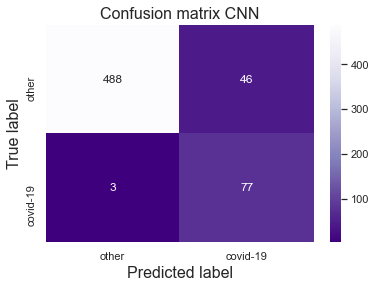

In [59]:
ypred = model03.predict(X_test )
cm1 = confusion_matrix(np.argmax(y_test,1),np.argmax(ypred,1))
sns.heatmap(cm1,annot = True, fmt = '.0f', cmap = 'Purples_r',
            yticklabels = ['other','covid-19'],xticklabels = ['other','covid-19'])
plt.title('Confusion matrix CNN',size = 16)
plt.xlabel('Predicted label',size = 16)
plt.ylabel('True label',size = 16)
plt.show()

model03's recall (.96) is better than model01's (.85). But, from the two confusion matrices we can see that model01 only misclassifies 2 covid-negative patients as covid-positive while model03 misclassifies 30 covid-negative patients as covid-positive. We can thus deduce that even though model03's  recall is better, the precision of model01 is better. To end the CNN part, we will be adding a hard and soft voting to increase their overall performance.

In [60]:
# predicts the class based on the outputs of three classifiers
def soft_voting(model1,model2,X1,X2):
    pred1= model1.predict(X1)
    pred2 = model2.predict(X2)
    avg_pred = np.round((pred1+pred2)/2)
    return avg_pred


In [61]:
model01 = build_model01()
model03 = build_model02()
model01.load_weights('./weights/model01_weights.h5')
model03.load_weights('./weights/model03_weights.h5')

In [62]:
soft_pred = soft_voting(model01,model03,X_final.reshape(-1,255,237,1), crop(X_final).reshape(3070,255,-1,1))

In [63]:
from sklearn import metrics
print(metrics.classification_report(np.argmax(soft_pred,1), np.argmax(y_bin, 1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2741
           1       0.94      0.98      0.96       329

    accuracy                           0.99      3070
   macro avg       0.97      0.99      0.98      3070
weighted avg       0.99      0.99      0.99      3070



# Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier
from numpy import argmax

#data processeing , random forest only accepts 1dim data
xtrain_rf= X_train.reshape(-1,255*X_train.shape[-2])
xtest_rf=X_test.reshape(-1,255*X_train.shape[-2])

Randomized search cross validation to find the best hyperparamters of the Random Forest Model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain_rf,y_train)
#return the best parameters 
rf_random.best_params_

**Best parameters obtained :**

n_estimators = 350 / random_state = 42 / min_samples_split=5 / min_samples_leaf=1 / max_features='sqrt' / max_depth=30 / bootstrap= False 

In [31]:
#Building random Forest Classifier with RandomSearchCV best parameters 
base_model = RandomForestClassifier(n_estimators = 350, random_state = 42, min_samples_split=5,min_samples_leaf=1, max_features='sqrt', max_depth=30, bootstrap= False )
base_model.fit(xtrain_rf,y_train)

#Evaluating the model 
from sklearn import metrics
y_pred=base_model.predict(xtest_rf)
print("Recall score:",metrics.recall_score(argmax(y_test, axis=1), argmax(y_pred, axis=1)))
print(metrics.classification_report(argmax(y_test, axis=1), argmax(y_pred, axis=1)))

Recall score: 0.85
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       534
           1       0.92      0.85      0.88        80

    accuracy                           0.97       614
   macro avg       0.95      0.92      0.93       614
weighted avg       0.97      0.97      0.97       614



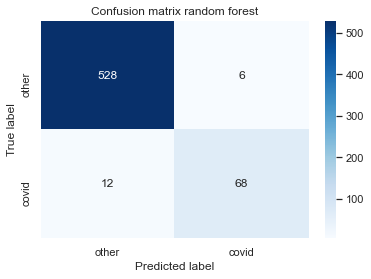

In [66]:
from sklearn.metrics import confusion_matrix

def binary_cm(y_test,y_pred, model_str):
    cm=confusion_matrix(argmax(y_test, axis=1),argmax(y_pred, axis=1))
    #print(cm)
    cm_n=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    import seaborn as sns 
    df_cm = pd.DataFrame(cm, index = [i for i in ['other','covid']],
                      columns = [i for i in ['other','covid']])
    #plt.figure(figsize = (10,7))
    ax = plt.axes()
    sns.heatmap(df_cm, annot=True, fmt = '.0f', cmap='Blues')
    ax.set_title('Confusion matrix ' + model_str)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

binary_cm(y_test,y_pred, 'random forest' )

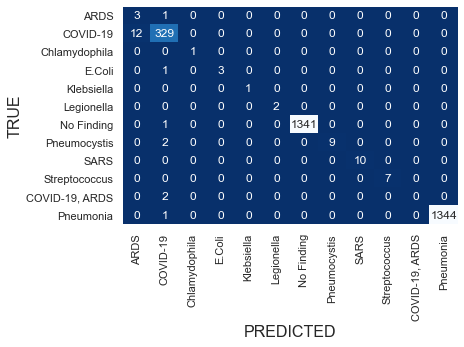

In [67]:
model = base_model
y_bin_pred = np.argmax(model.predict(crop(X_final).reshape(-1,255*X_train.shape[-2])),1)
y_pred_updated = np.ones(y_bin_pred.shape,dtype = int)
for count,i in enumerate(y_bin_pred):
    if i ==0 and y_final[count] !=1 :
        y_pred_updated[count] = y_final[count]
    elif i == 0:
        y_pred_updated[count] = 0
tick = list(dico_findings.keys())
tick.append('Pneumonia')
cm1 = confusion_matrix(y_final,y_pred_updated)
sns.heatmap(cm1,annot= True,cmap = 'Blues_r',cbar = False,yticklabels = tick,
            xticklabels = tick,fmt = '.0f'  )
plt.xlabel('PREDICTED',size = 16)
plt.ylabel('TRUE',size = 16)
plt.show()

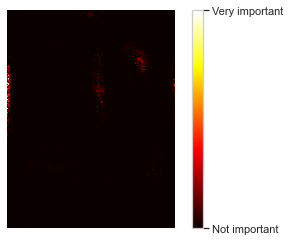

In [68]:
#visualizing the model's best features of the xray images

data= base_model.feature_importances_
image = data.reshape(255, X_train.shape[-2])

plt.imshow(image, cmap = 'hot', interpolation="nearest")

plt.axis("off")
cbar = plt.colorbar(ticks=[base_model.feature_importances_.min(), base_model.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

#plt.savefig('random_forest_feature_importance_covid19.png', dpi=200)  
plt.show()

Soft voting between the CNN models and the RF

In [32]:
def soft_voting_fn(model1,model2,model3,X1,X2,X3):
    pred1= model1.predict(X1)
    pred2 = model2.predict(X2)
    pred3 = model3.predict(X3)
    avg_pred = np.round((pred1+pred2+pred3)/3)
    return avg_pred

In [33]:
soft_pred_fin = soft_voting_fn(model01,model03,base_model,
                            X_final.reshape(-1,255,237,1), crop(X_final).reshape(3070,255,-1,1),
                            crop(X_final).reshape(3070,-1))

In [35]:
print(metrics.classification_report(np.argmax(soft_pred_fin,1), np.argmax(y_bin, 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2728
           1       0.98      0.98      0.98       342

    accuracy                           1.00      3070
   macro avg       0.99      0.99      0.99      3070
weighted avg       1.00      1.00      1.00      3070



------------------------------------------------------ 
--------------------------------
------------------

**End.** 